In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install datasets evaluate transformers soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Input, BatchNormalization, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import BaggingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import librosa
import glob
import os
import random
from scipy.io import wavfile
import evaluate
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import soundfile



In [ ]:
from datasets import load_dataset, Audio
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer, pipeline
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Embedding, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention, Input, BatchNormalization, GRU
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
# Emotion mappings
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Set of observed emotions
observed_emotions = {'calm', 'happy', 'fearful', 'disgust'}

# Function to extract features from audio file
def extract_feature(file_name, mfcc, chroma, mel, zcr, rmse):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel_spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate)
            mel = np.mean(mel_spectrogram.T, axis=0)  # Average over time
            result = np.hstack((result, mel))
        if zcr:
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result = np.hstack((result, zcr))
        if rmse:
            rmse = np.mean(librosa.feature.rms(S=stft).T, axis=0)
            result = np.hstack((result, rmse))
    return result

# Function to load data and split into train/test sets
def load_data(test_size=0.2):
    x, y = [], []
    files = glob.glob("/content/drive/MyDrive/archive/Actor_*/*.wav")
    if len(files) == 0:
        raise ValueError("No audio files found in the specified directory.")

    num_files_to_sample = min(len(files), 50)
    selected_files = random.sample(files, num_files_to_sample)
    print(f"Selected {len(selected_files)} files for processing.")

    for file in selected_files:
        try:
            file_name = os.path.basename(file)
            emotion = emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                print(f"Skipping file {file_name} due to unobserved emotion: {emotion}")
                continue
            feature = extract_feature(file, mfcc=True, chroma=True, mel=True, zcr=True, rmse=True)
            x.append(feature)
            y.append(emotion)
            print(f"Processed file {file_name} with emotion: {emotion}")
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    return train_test_split(np.array(x), y, test_size=test_size)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

Selected 50 files for processing.
Skipping file 03-01-05-01-02-01-24.wav due to unobserved emotion: angry
Skipping file 03-01-04-01-02-01-11.wav due to unobserved emotion: sad
Skipping file 03-01-05-02-01-02-02.wav due to unobserved emotion: angry
Skipping file 03-01-05-02-01-02-14.wav due to unobserved emotion: angry
Skipping file 03-01-04-02-01-01-22.wav due to unobserved emotion: sad
Skipping file 03-01-05-01-02-02-01.wav due to unobserved emotion: angry
Processed file 03-01-07-02-02-01-10.wav with emotion: disgust
Skipping file 03-01-08-02-02-01-11.wav due to unobserved emotion: surprised
Skipping file 03-01-05-01-01-02-03.wav due to unobserved emotion: angry
Skipping file 03-01-04-02-01-01-23.wav due to unobserved emotion: sad
Processed file 03-01-06-01-01-02-23.wav with emotion: fearful
Skipping file 03-01-05-02-01-02-17.wav due to unobserved emotion: angry
Processed file 03-01-02-02-02-02-02.wav with emotion: calm
Processed file 03-01-03-01-02-01-16.wav with emotion: happy
Skipp

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


Error processing file /content/drive/MyDrive/archive/Actor_05/03-01-02-01-02-02-05.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
Skipping file 03-01-01-01-02-01-21.wav due to unobserved emotion: neutral
Processed file 03-01-07-02-01-01-21.wav with emotion: disgust
Processed file 03-01-02-02-02-02-13.wav with emotion: calm
Skipping file 03-01-01-01-02-02-17.wav due to unobserved emotion: neutral
Processed file 03-01-02-02-01-02-18.wav with emotion: calm
Processed file 03-01-06-01-02-02-23.wav with emotion: fearful
Skipping file 03-01-08-02-01-01-21.wav due to unobserved emotion: surprised
Skipping file 03-01-08-01-01-01-08.wav due to unobserved emotion: surprised
Skipping file 03-01-01-01-01-01-14.wav due to unobserved emotion: neutral
Skipping file 03-01-05-01-02-02-08.wav due to unobserved emotion: angry
Processed file 03-01-06-01-02-01-10.wav with emotion: fearful
Processed file 0

In [ ]:
print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")

Training data shape: (20, 182), Test data shape: (6, 182)


In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


In [ ]:
# Determine number of mel features dynamically
dummy_audio = np.zeros((22050,))  # 1 second of silence at 22050 Hz
num_mel_features = librosa.feature.melspectrogram(y=dummy_audio, sr=22050).shape[0]

# Update feature names based on actual extracted features
feature_names = (
    [f"mfcc_{i+1}" for i in range(40)] +
    [f"chroma_{i+1}" for i in range(12)] +
    [f"mel_{i+1}" for i in range(num_mel_features)] +
    ['zcr'] +
    ['rmse']
)

# Ensure feature names match the number of columns
feature_names = feature_names[:x_train.shape[1]]

# Create a DataFrame for the training data
df_train = pd.DataFrame(x_train, columns=feature_names)
df_train['emotion'] = y_train

# Print the first few rows of the DataFrame
print(df_train.head())

# Print the shape of the training and testing data
print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")

       mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -701.593201  69.742020   2.556649  15.458294  -4.493708  12.849492   
1 -635.940796  84.693466   1.974038   7.556933  10.839379  14.417017   
2 -490.204803  50.333805 -18.540890  14.203277  -5.772608   0.568333   
3 -609.407410  89.939926   0.727012  11.671098   4.483903  19.264565   
4 -626.364380  85.229454  -3.581933   9.515907   7.661771  19.551548   

      mfcc_7    mfcc_8     mfcc_9   mfcc_10  ...       mel_122       mel_123  \
0 -10.054173  4.526251  -8.399968 -6.135711  ...  4.559469e-07  2.060225e-07   
1  -3.932061  4.065408   3.045051 -0.072319  ...  1.798785e-07  1.240103e-07   
2 -11.674704  2.123715 -13.284012 -3.700049  ...  1.630508e-05  1.663261e-05   
3  -5.854645  0.520952  -5.034028 -3.923336  ...  9.956668e-07  4.636946e-07   
4  -8.907881  4.193798   1.711481 -6.687214  ...  1.685490e-06  1.308372e-06   

        mel_124       mel_125       mel_126       mel_127       mel_128  \
0  1.272304

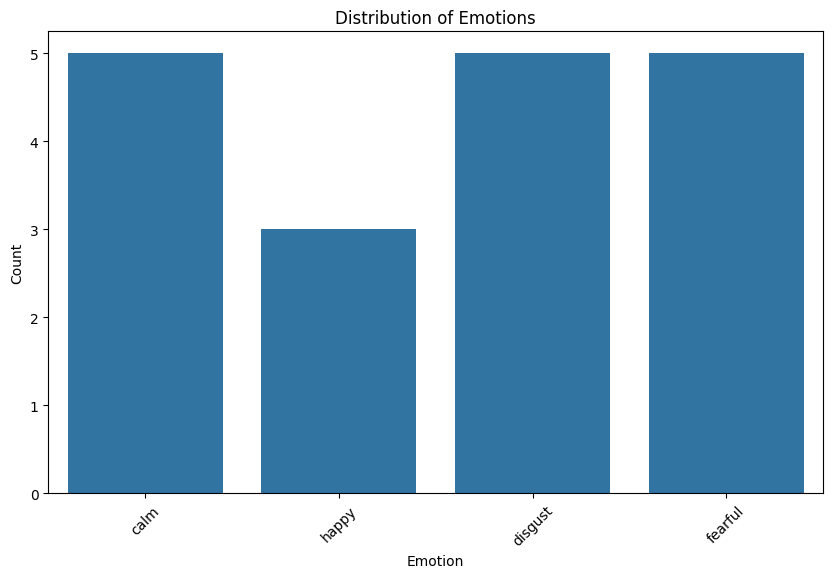

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df_train)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


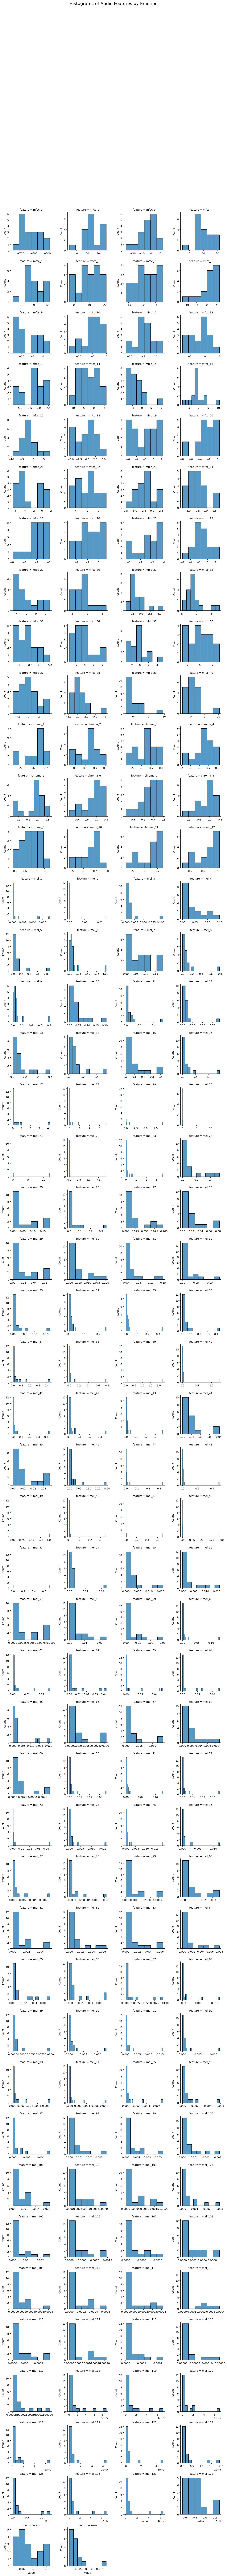

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df_train is defined
# df_train = pd.DataFrame(x_train, columns=feature_names)
# df_train['emotion'] = y_train

# Melt the DataFrame for plotting
df_melt = df_train.melt(id_vars='emotion', var_name='feature', value_name='value')

# Create the FacetGrid
g = sns.FacetGrid(df_melt, col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Histograms of Audio Features by Emotion', fontsize=16)
plt.show()


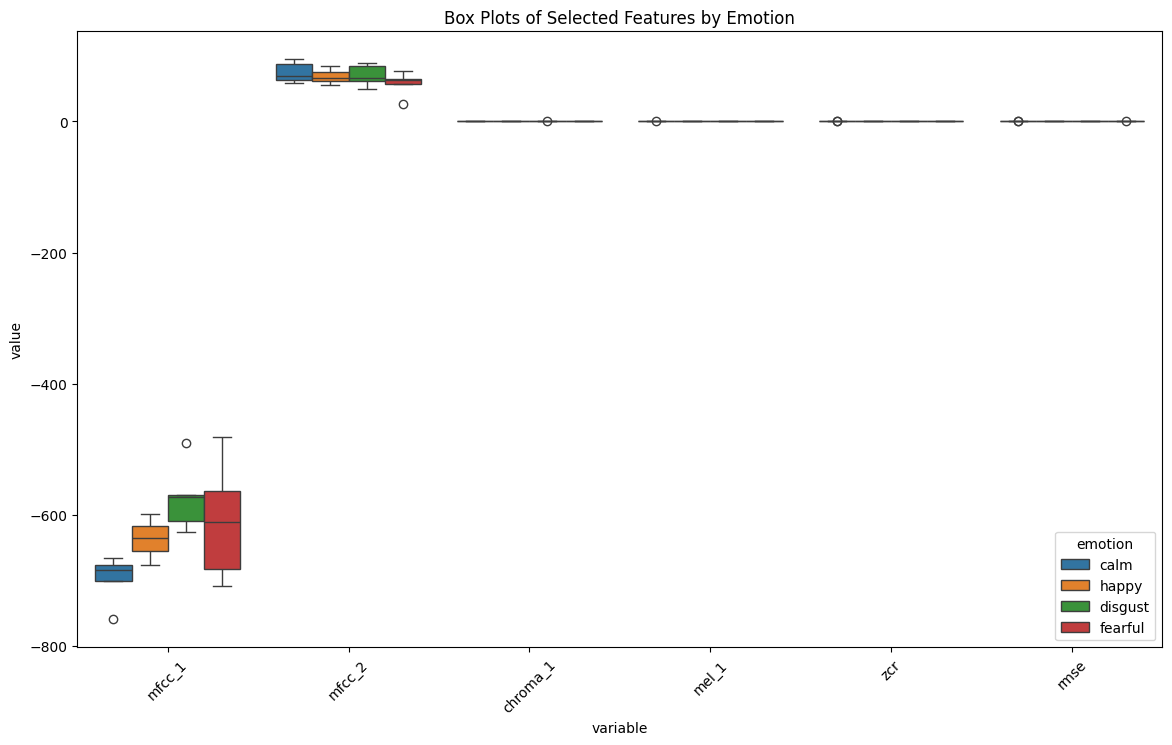

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the selected features
selected_features = ['mfcc_1', 'mfcc_2', 'chroma_1', 'mel_1', 'zcr', 'rmse']

# Create a DataFrame with the selected features and the emotion label
df_selected = df_train[selected_features + ['emotion']]

# Plot box plots of the selected features by emotion
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_selected.melt(id_vars='emotion'), x='variable', y='value', hue='emotion')
plt.title('Box Plots of Selected Features by Emotion')
plt.xticks(rotation=45)
plt.show()


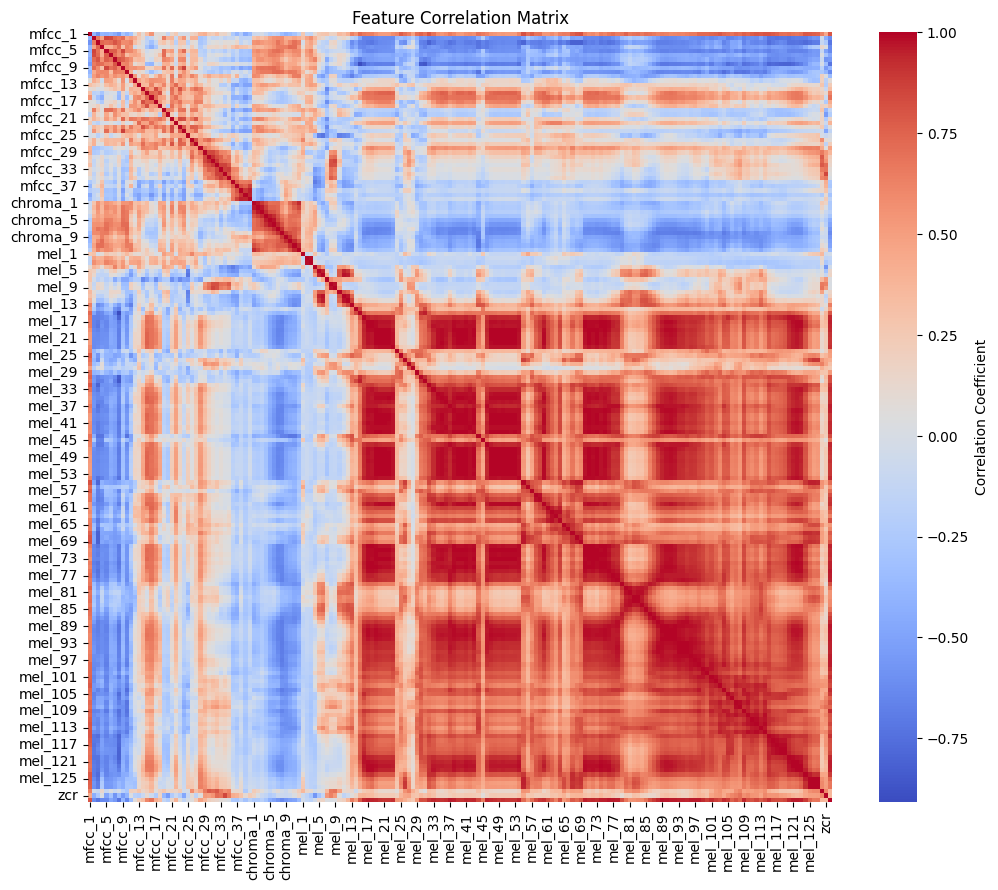

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude non-numeric columns (like 'emotion') from the correlation calculation
numeric_df_train = df_train.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded)

In [ ]:
x_train_cnn = x_train[..., np.newaxis]
x_test_cnn = x_test[..., np.newaxis]
x_train_rnn = x_train[:, np.newaxis, :]
x_test_rnn = x_test[:, np.newaxis, :]
x_train_transformer = x_train[:, np.newaxis, :]
x_test_transformer = x_test[:, np.newaxis, :]

In [ ]:
num_classes = y_train_cat.shape[1]
print(f"Number of classes: {num_classes}")

Number of classes: 4


CNN model

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape_cnn = (x_train_cnn.shape[1], x_train_cnn.shape[2], 1)
cnn_model = create_cnn_model(input_shape_cnn, num_classes)
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 182, 1, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 91, 1, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 91, 1, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 91, 1, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 91, 1, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 1, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 22, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,612 (799.27 KB)

 Trainable params: 204,388 (798.39 KB)

 Non-trainable params: 224 (896.00 B)

Bi LSTM model

In [ ]:
def create_rnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape_rnn = (x_train_rnn.shape[1], x_train_rnn.shape[2])
rnn_model = create_rnn_model(input_shape_rnn, num_classes)
rnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │         159,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,844 (1.17 MB)

 Trainable params: 307,844 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Transformer model

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def create_transformer_model(input_shape, num_classes, head_size=256, num_heads=4, ff_dim=256, num_blocks=4, dropout=0.3):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    x = Dropout(dropout)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape_transformer = (x_train_transformer.shape[1], x_train_transformer.shape[2])
transformer_model = create_transformer_model(input_shape_transformer, num_classes)
transformer_model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 182)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 182)         │        748,726 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 1, 182)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 182)         │            364 │ dropout_8[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 182)         │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 256)         │         46,848 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 1, 256)         │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 182)         │         46,774 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 1, 182)         │            364 │ dense_5[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1, 182)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 182)         │        748,726 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 1, 182)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 182)         │            364 │ dropout_11[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 182)         │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 256)         │         46,848 │ add_2[0][0]            │
├──────────────────────

 Total params: 3,396,244 (12.96 MB)

 Trainable params: 3,396,244 (12.96 MB)

 Non-trainable params: 0 (0.00 B)

Auto-encoder model

In [ ]:
def create_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    encoder = Dense(128, activation="relu")(input_layer)
    encoder = Dense(64, activation="relu")(encoder)
    encoder = Dense(32, activation="relu")(encoder)

    decoder = Dense(64, activation="relu")(encoder)
    decoder = Dense(128, activation="relu")(decoder)
    decoder = Dense(input_shape[0], activation="sigmoid")(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

input_shape_autoencoder = (x_train.shape[1],)
autoencoder = create_autoencoder(input_shape_autoencoder)
autoencoder.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 182)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          23,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 182)                 │          23,478 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,670 (264.34 KB)

 Trainable params: 67,670 (264.34 KB)

 Non-trainable params: 0 (0.00 B)

GRU model

In [ ]:
def create_gru_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(GRU(128))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape_gru = (x_train_rnn.shape[1], x_train_rnn.shape[2])
gru_model = create_gru_model(input_shape_gru, num_classes)
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │         119,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,908 (921.52 KB)

 Trainable params: 235,908 (921.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

In [ ]:
batch_size = 32
epochs = 100

In [ ]:
cnn_history = cnn_model.fit(x_train_cnn, y_train_cat, validation_data=(x_test_cnn, y_test_cat), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
cnn_accuracy = cnn_model.evaluate(x_test_cnn, y_test_cat)[1]
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2778 - loss: 2.3082 - val_accuracy: 0.2000 - val_loss: 1.4918 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3889 - loss: 1.9705 - val_accuracy: 0.2000 - val_loss: 1.3911 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.3889 - loss: 1.6039 - val_accuracy: 0.2000 - val_loss: 1.3518 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5556 - loss: 1.3124 - val_accuracy: 0.2000 - val_loss: 1.3290 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.2778 - loss: 2.1237 - val_accuracy: 0.2000 - val_loss: 1.3216 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2222 - loss: 1.5351 - val_accuracy: 0.2000 - val_loss: 1.3276 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3889 - loss: 2.0123 - val_accuracy:

In [ ]:
rnn_history = rnn_model.fit(x_train_rnn, y_train_cat, validation_data=(x_test_rnn, y_test_cat), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
rnn_accuracy = rnn_model.evaluate(x_test_rnn, y_test_cat)[1]
print(f"RNN (Bi-LSTM) Test Accuracy: {rnn_accuracy * 100:.2f}%")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1667 - loss: 1.3865 - val_accuracy: 0.2000 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3889 - loss: 1.3935 - val_accuracy: 0.2000 - val_loss: 1.3860 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step - accuracy: 0.1667 - loss: 1.4007 - val_accuracy: 0.2000 - val_loss: 1.3881 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.2778 - loss: 1.3840 - val_accuracy: 0.2000 - val_loss: 1.3899 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.1111 - loss: 1.4047 - val_accuracy: 0.2000 - val_loss: 1.3912 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1667 - loss: 1.4151 - val_accuracy: 0.2000 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.1667 - loss: 1.3861 - val_accura

In [ ]:
transformer_history = transformer_model.fit(x_train_transformer, y_train_cat, validation_data=(x_test_transformer, y_test_cat), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
transformer_accuracy = transformer_model.evaluate(x_test_transformer, y_test_cat)[1]
print(f"Transformer Test Accuracy: {transformer_accuracy * 100:.2f}%")

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1667 - loss: 102.1558 - val_accuracy: 0.2000 - val_loss: 31.7928 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.0556 - loss: 80.2398 - val_accuracy: 0.0000e+00 - val_loss: 20.5766 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1667 - loss: 94.7440 - val_accuracy: 0.0000e+00 - val_loss: 12.7751 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.1667 - loss: 67.1471 - val_accuracy: 0.0000e+00 - val_loss: 5.7112 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.3333 - loss: 60.0011 - val_accuracy: 0.4000 - val_loss: 4.0559 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.3333 - loss: 54.2841 - val_accuracy: 0.4000 - val_loss: 6.7451 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.2222 - loss: 40.9383

In [ ]:
autoencoder_history = autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
autoencoder_encoded_train = autoencoder.predict(x_train)
autoencoder_encoded_test = autoencoder.predict(x_test)
autoencoder_classifier = SVC(kernel='linear')
autoencoder_classifier.fit(autoencoder_encoded_train, y_train_encoded)
autoencoder_pred = autoencoder_classifier.predict(autoencoder_encoded_test)
autoencoder_accuracy = accuracy_score(y_test_encoded, autoencoder_pred)
print(f"Autoencoder + SVM Test Accuracy: {autoencoder_accuracy * 100:.2f}%")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2240.7134 - val_loss: 2070.7515 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 2234.2236 - val_loss: 2069.8601 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2233.2517 - val_loss: 2069.5872 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2232.9414 - val_loss: 2069.5266 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2232.8640 - val_loss: 2069.5066 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2232.8369 - val_loss: 2069.4897 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2232.8164 - val_loss: 2069.4714 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2232.7930 - val_loss: 2069.4526 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2232.7690 - val_loss: 2069.4331

In [ ]:
gru_history = gru_model.fit(x_train_rnn, y_train_cat, validation_data=(x_test_rnn, y_test_cat), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
gru_accuracy = gru_model.evaluate(x_test_rnn, y_test_cat)[1]
print(f"GRU Test Accuracy: {gru_accuracy * 100:.2f}%")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2222 - loss: 1.5167 - val_accuracy: 0.2000 - val_loss: 1.4100 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.2222 - loss: 1.3522 - val_accuracy: 0.2000 - val_loss: 1.3819 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2222 - loss: 1.4581 - val_accuracy: 0.4000 - val_loss: 1.3623 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2222 - loss: 1.3177 - val_accuracy: 0.4000 - val_loss: 1.3584 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1111 - loss: 1.4396 - val_accuracy: 0.4000 - val_loss: 1.3546 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2222 - loss: 1.4575 - val_accuracy: 0.4000 - val_loss: 1.3524 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3333 - loss: 1.3423 - val_accurac

SVM

In [ ]:
svm_model = SVC(kernel='rbf')
svm_model.fit(x_train, y_train_encoded)
svm_pred = svm_model.predict(x_test)
svm_accuracy = accuracy_score(y_test_encoded, svm_pred)
print(f"SVM Test Accuracy: {svm_accuracy * 100:.2f}%")

SVM Test Accuracy: 60.00%


Hidden Markov machine

In [ ]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm

In [ ]:
hmm_model = hmm.GaussianHMM(n_components=len(np.unique(y_train_encoded)), covariance_type="diag", n_iter=100)
hmm_model.fit(x_train)
hmm_pred = hmm_model.predict(x_test)
hmm_accuracy = accuracy_score(y_test_encoded, hmm_pred)
print(f"HMM Test Accuracy: {hmm_accuracy * 100:.2f}%")

HMM Test Accuracy: 0.00%


XGBoosting

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train_encoded)
xgb_pred = xgb_model.predict(x_test)
xgb_accuracy = accuracy_score(y_test_encoded, xgb_pred)
print(f"XGBoost Test Accuracy: {xgb_accuracy * 100:.2f}%")

XGBoost Test Accuracy: 60.00%


Decision Tree classifier

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train_encoded)
dt_pred = dt_model.predict(x_test)
dt_accuracy = accuracy_score(y_test_encoded, dt_pred)
print(f"Decision Tree Test Accuracy: {dt_accuracy * 100:.2f}%")

Decision Tree Test Accuracy: 40.00%


Adaboosting

In [ ]:
ada_model = AdaBoostClassifier()
ada_model.fit(x_train, y_train_encoded)
ada_pred = ada_model.predict(x_test)
ada_accuracy = accuracy_score(y_test_encoded, ada_pred)
print(f"AdaBoost Test Accuracy: {ada_accuracy * 100:.2f}%")

AdaBoost Test Accuracy: 60.00%


In [ ]:
results = {
    "CNN": cnn_accuracy,
    "Bi-LSTM": rnn_accuracy,
    "Transformer": transformer_accuracy,
    "Autoencoder + SVM": autoencoder_accuracy,
    "GRU": gru_accuracy,
    "SVM": svm_accuracy,
    "HMM": hmm_accuracy,
    "XGBoost": xgb_accuracy,
    "Decision Tree": dt_accuracy,
    "AdaBoost": ada_accuracy
}
print("Model Performance:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy * 100:.2f}%")

Model Performance:
CNN: 20.00%
Bi-LSTM: 20.00%
Transformer: 20.00%
Autoencoder + SVM: 60.00%
GRU: 20.00%
SVM: 60.00%
HMM: 0.00%
XGBoost: 60.00%
Decision Tree: 40.00%
AdaBoost: 60.00%
